In [2]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5

In [3]:
sys.path.append("../..")

In [4]:
from source.NAHEA_CNN import NAHEA_CNN_1

In [5]:
# load data from sin dataset
data_save_dir = Path("../../data") / "sin"
data_save_path_train = data_save_dir / "train.h5"
data_save_path_test = data_save_dir / "test.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train = f["X"][:].squeeze(2)
    y_train = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test = f["X"][:].squeeze(2)
    y_test = f["y"][:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 18)
y_train shape: (4000, 1)
X_test shape: (1000, 18)
y_test shape: (1000, 1)


In [6]:
n_train = 150
n_test = 500 # testing is much faster than training
X_train = X_train[:n_train]
y_train = y_train[:n_train]
X_test = X_test[:n_test]
y_test = y_test[:n_test]

In [7]:
# plot settings for paper
plt.rcParams.update({
    "font.size": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "figure.titlesize": 16,
    "axes.titlesize": 16,
    "lines.linewidth": 2,
    "axes.grid": True,
    "grid.alpha": 0.5,
    "figure.figsize": (8, 6),
    "figure.dpi": 100,
    "savefig.dpi": 100,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.1,
    "savefig.transparent": True,
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
    "xtick.major.pad": 5,
    "ytick.major.pad": 5,
    "xtick.minor.pad": 5,
    "ytick.minor.pad": 5,
    "legend.loc": "best",
    "legend.frameon": False,
    "legend.borderpad": 0.5,
    "legend.handlelength": 2,
    "legend.handletextpad": 0.5,
    "legend.columnspacing": 1.0,
    "legend.labelspacing": 0.5,
    "legend.borderaxespad": 0.5,
    "lines.markersize": 8,
    "lines.markeredgewidth": 1.0,
    "lines.markerfacecolor": "none",
    "lines.markeredgecolor": "black",
    "lines.linestyle": "-",
    "lines.color": "black",
    "axes.prop_cycle": plt.cycler(color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]),
})

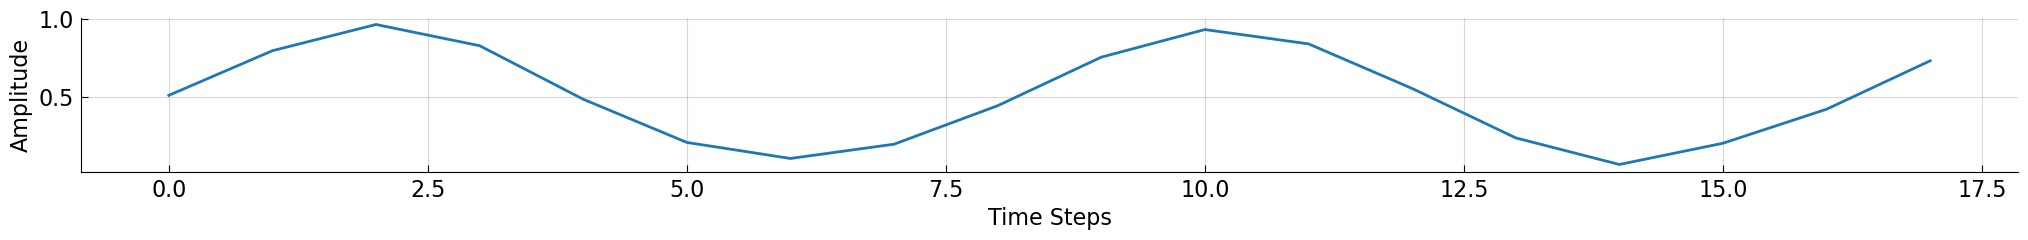

In [11]:
# plot some data
plt.figure(figsize=(25, 2))
for i in range(1):
    plt.plot(X_train[i], label=f"Sample {i+1}, f= {y_train[i][0]:.2f}")
# plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
# make background transparent
plt.gca().set_facecolor("white")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(True)
plt.gca().spines["bottom"].set_visible(True)
# plt.legend()
plt.show()

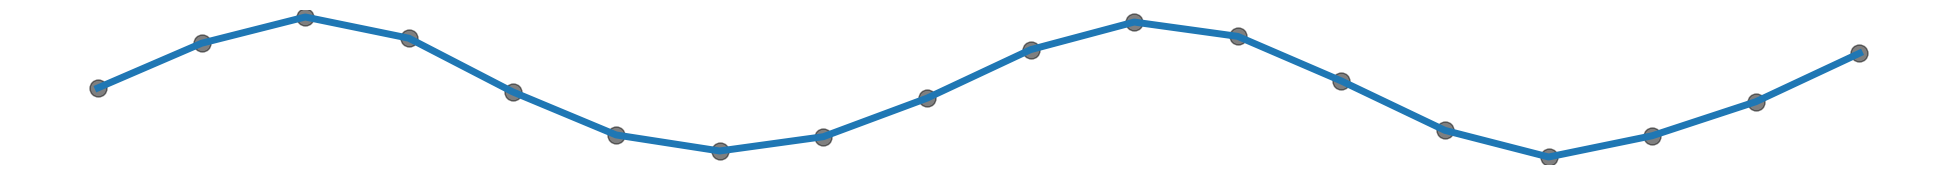

In [33]:
# plot some data
plt.figure(figsize=(25, 2))
for i in range(1):
    plt.plot(X_train[i], label=f"Sample {i+1}, f= {y_train[i][0]:.2f}", lw=5)
    plt.scatter(
        np.arange(len(X_train[i])),
        X_train[i],
        s=150,
        color="black",
        alpha=0.5,
        label="Data Points"
    )
# plt.title("Generated Sin Wave Data Samples")
# plt.xlabel("Time Steps")
# plt.ylabel("Amplitude")
# remove tick labels
plt.xticks([])
plt.yticks([])
# make background transparent
plt.gca().set_facecolor("white")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
# remove x and y axis completely
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
# remove grid
plt.gca().grid(False)
path = Path("figures") / "sin_data_plot.png"
os.makedirs(path.parent, exist_ok=True)
plt.savefig(path, dpi=300, bbox_inches='tight', transparent=True)
plt.show()